# Feature Selection with a General Regression Neural Network

In this notebook we will explore the main functionalities of the PyGRNN package, including the possibility of analyzing data dependecies (i.e. enderstanding the non-linear relationships among the features included in the input space), of performing feature selection and of using General Regression Neural Networks (GRNN) to solve regression problems. 
First, let's import some useful library, including PyGRNN

In [1]:
import pandas as pd
import numpy as np 
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split, GridSearchCV

from pyGRNN import GRNN #imports the GRNN regressor module
from pyGRNN import feature_selection as FS #imports the GRNN feature selector module

In this example, we will perform our analysis on simulated data. We will use the "butterfly" dataset proposed in the paper "Golay, J., et.al. Feature selection for regression problems based on the Morisita estimator of intrinsic dimension. Pattern Recognition 70 (2017): 126-138 (https://www.sciencedirect.com/science/article/pii/S0031320317301905)". The dataset is available at https://www.sites.google.com/site/jeangolayresearch/r-codes-and-datasets.

In this synthetic dataset an output variable Y is generated from two uniformly distributed input variables X1 and X2 by using an Artificial Neural Network with one hidden layer of ten neurons, a sigmoid transfer function, randomly generated weights ∈ [−2, 2] and no biases.
The dataset includes also three redundant (J3 = log(X1 + 5), J4 = X1^2-X2^2, J5 = X1^4-X2^4) and three irrelevant (I6 uniformly distributed, I7 = log(I6 + 5) and I8 = I6 + I7) input variables. For this exercize, we only generated 2000 observations.

In the following lines of code we will load the dataset, extract the target variable to an array "y" and put the features into an array "X". We will then split the dataset into training (75% of observation) and testing (25%) points. We will also create a list with the names of the features, as we will need it to plot the results of feature selection.

In [2]:
butterfly = pd.read_csv("butterfly_n2000.csv", index_col = 0)

y = butterfly['Y'].values.ravel()
X = butterfly.drop(["Y"], axis = 1).values
X_train, X_test, y_train, y_test = train_test_split(preprocessing.minmax_scale(X), y.reshape((-1, 1)), test_size=0.25, random_state = 42)

featnames=list(butterfly.drop(["Y"], axis = 1).columns)

We start with some exploratory data analysis. The name "butterfly" derives from the shape drawn by the data in the 3-d space constituted by the two relevant features (i.e. X1 and X2) and the output Y. When plotting the output versus the redundant or the irrelevant features, we are not able to reproduce the butterfly shape: this is an intuitive way to understand why those features are not relevant. 

Text(0.5,0,'Y')

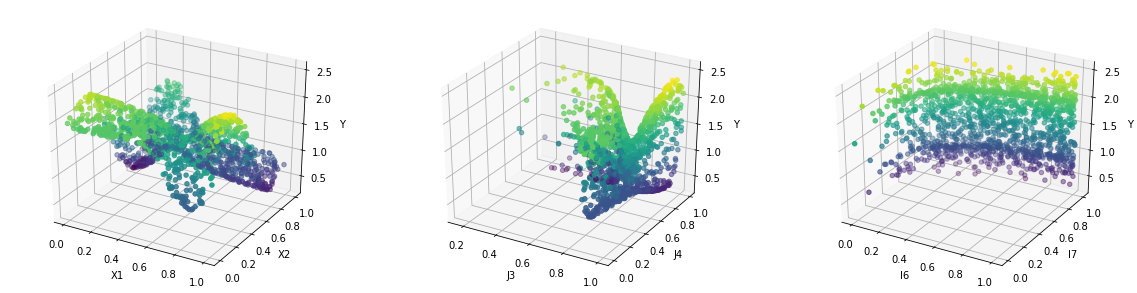

In [3]:
fig = plt.figure(figsize=[20,5])
ax = fig.add_subplot(131, projection='3d')
ax.scatter(X_train[:,0], X_train[:,1], y_train, c=y_train[:,0], marker='o')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')

#fig = plt.figure(figsize=[10,8])
ax = fig.add_subplot(132, projection='3d')
ax.scatter(X_train[:,2], X_train[:,3], y_train, c=y_train[:,0], marker='o')
ax.set_xlabel('J3')
ax.set_ylabel('J4')
ax.set_zlabel('Y')

#fig = plt.figure(figsize=[10,8])
ax = fig.add_subplot(133, projection='3d')
ax.scatter(X_train[:,5], X_train[:,6], y_train, c=y_train[:,0], marker='o')
ax.set_xlabel('I6')
ax.set_ylabel('I7')
ax.set_zlabel('Y')

Now let's consider the input space. We already know that features were generated to have linear and non-linear relationship between each other. How does these relationship look like? We can visualize them in a scatterplot matrix. For simplicity, we will use the entire dataset so that we can plot using the pandas.plotting options.

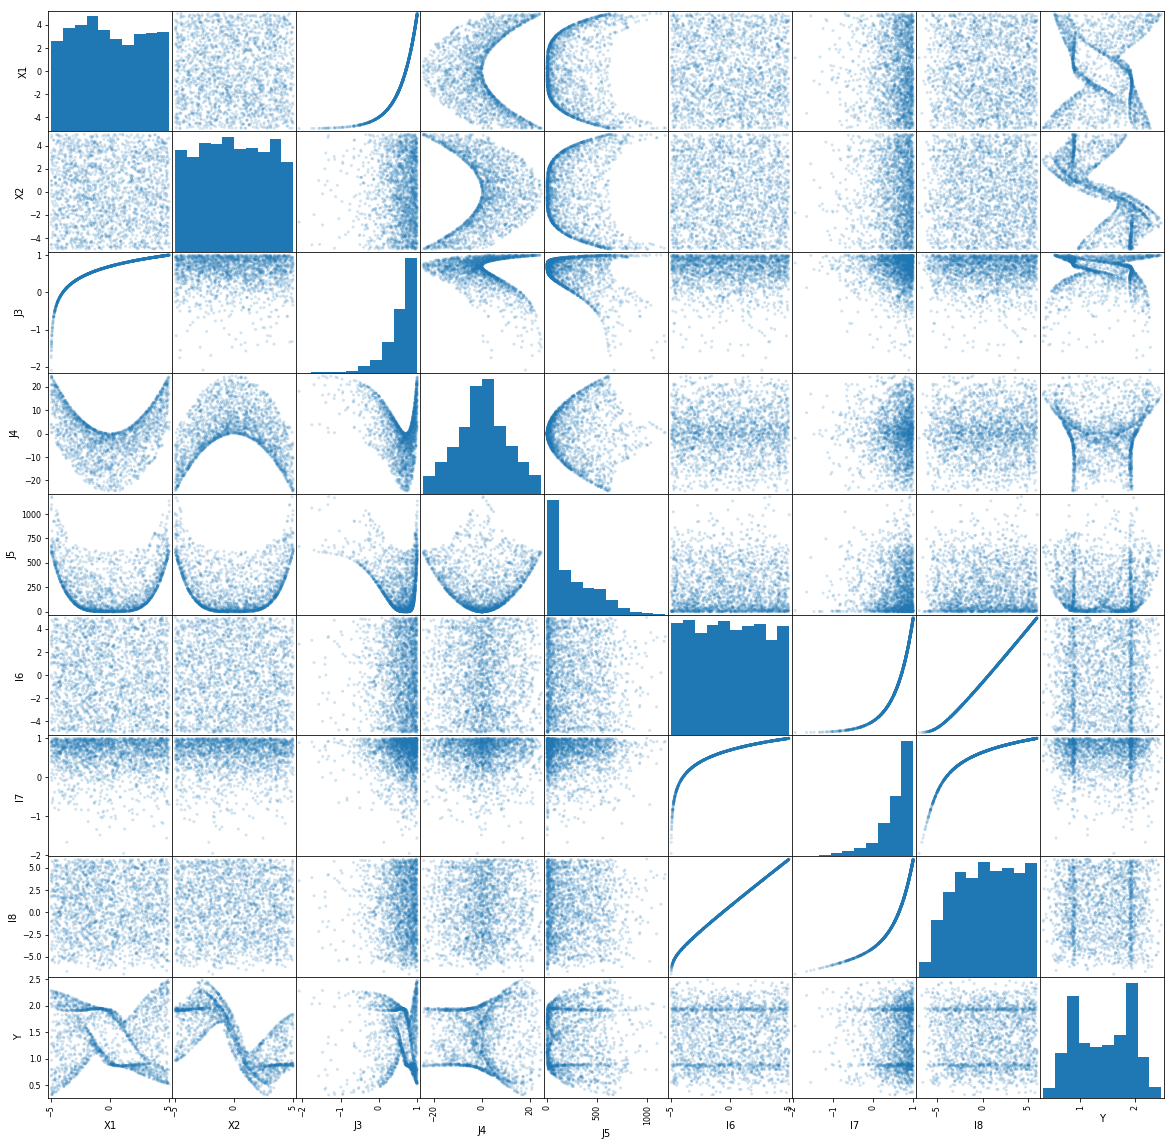

In [4]:
pd.plotting.scatter_matrix(butterfly, alpha=0.2, figsize=(20,20))
plt.show()

The last row of the scatterplot matrix shows the pairwise relationships between the target variable Y and the features: we can clearly see how I6, I7 and I8 have no relationship with Y. 
The scatterplot matrix also highlights the nonlinear relationship between pair of features, like the relationship between J3 and X1. It has to be considered that this relationship appear clear in the scatterplot matrix because we are working with simulated data. Real data rarely have this nice scatterplot matrix!

Now we are ready to move to feature selection with PyGRNN. Our first step is the analysis of data dependencies in the input space through the concept of "relatidness" - i.e. the nonlinear predictability of each feature of the input space using all the others. We will select one feature per time and we will search the best subset of all the other features to predict it (using the CV error as criterion for the evaluation). 
We will plot the results in a binary heatmap having on the abscissa the predicted variable and on the vertical axes the predicting features. We here choose to study the relatidness with a forward feature selection strategy.
In PyGRNN this is done through the Isotropic_selector module.

Searching relatidness for feature 0
Best subset is: ['J3']
Searching relatidness for feature 1
Best subset is: ['J5']
Searching relatidness for feature 2
Best subset is: ['X1']
Searching relatidness for feature 3
Best subset is: ['X1', 'X2', 'J3', 'J5']
Searching relatidness for feature 4
Best subset is: ['X1', 'X2', 'J3', 'J4']
Searching relatidness for feature 5
Best subset is: ['I8']
Searching relatidness for feature 6
Best subset is: ['I8']
Searching relatidness for feature 7
Best subset is: ['I6', 'I7']
Time to complete the search [s]: 0.8709316253662109


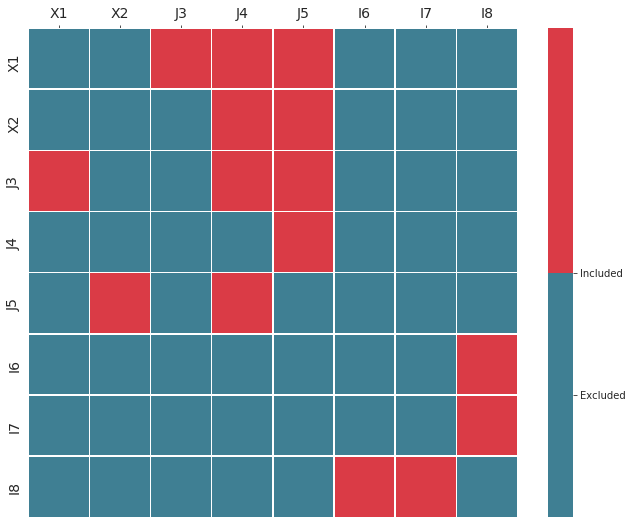

In [5]:
IsotropicSelector = FS.Isotropic_selector()

start = time.time()
IsotropicSelector.relatidness(X_train, feature_names=featnames, strategy = 'ffs')
IsotropicSelector.plot_(featnames)
print('Time to complete the search [s]: ' + str(time.time() - start))

The relatidness matrix helps us in graphically identifying two sets of features, namely the one including the relevant/redundant information for the output and the one including the irrelevant features. However, as it was obtained in an "unsupervised" way, we cannot a priori identify the group containing the relevant features. Hence, we combine the information of the relatidness with the one obtained from a supervised exhaustive search to clearly distinguish the relevant, redundant and irrelevant features. This can be done with a programmed "feature selection" option in the code of GRNN.

In the following lines of code we will perform a feature selection with the isotropic GRNN. We will use three strategies: the exhaustive search, forward and backward feature selection. In the three case we will test the different combination of features and we will rank them based on the MSE resulting from the appication of IGRNN. 
Finally we will use the feat_selection function, which automatically classifies the features into relevant, irrelevant and redundant.

In [6]:
print('Selecting the best subset of features using a forward fs strategy:')
start = time.time()
IsotropicSelector.ffs(X_train, y_train, feature_names=featnames)
print('Time to complete the search [s]: ' + str(time.time() - start))

Selecting the best subset of features using a forward fs strategy:
Best subset is: ['X1', 'X2', 'J4']
Time to complete the search [s]: 0.20073509216308594


In [7]:
print('Selecting the best subset of features using a backward fs strategy:')
start = time.time()
IsotropicSelector.bfs(X_train, y_train, feature_names=featnames)
print('Time to complete the search [s]: ' + str(time.time() - start))

Selecting the best subset of features using a backward fs strategy:
Best subset is: ['J4', 'X2', 'X1']
Time to complete the search [s]: 0.2993483543395996


In [8]:
print('Selecting the best subset of features using an exhaustive search:')
start = time.time()
IsotropicSelector.es(X_train, y_train, feature_names=featnames)
print('Time to complete the search [s]: ' + str(time.time() - start))

Selecting the best subset of features using an exhaustive search:
Exploring the 255 possible combination of features...
The best subset of features is ['X1', 'X2', 'J4']
Time to complete the search [s]: 2.011584758758545


In [9]:
print('Performing a complete feature selection from scratch:')
start = time.time()
IsotropicSelector.feat_selection(X_train, y_train, feature_names=featnames, strategy = 'ffs')
print('Time to complete the feature selection [s]: ' + str(time.time() - start))

Performing a complete feature selection from scratch:
Searching relevant features...
Best subset is: ['X1', 'X2', 'J4']
Searching the best subset to predict feature 0
Best subset is: ['J3']
[0, 1, 3, 4, 5, 6, 7]
Searching the best subset to predict feature 1
Best subset is: ['J5']
[0, 1, 2, 3, 5, 6, 7]
Searching the best subset to predict feature 3
Best subset is: ['X1', 'X2', 'J3', 'J5']
[3, 5, 6, 7]
Research completed!
The relevant features are: ['X1', 'X2', 'J4']
The redundant features are: ['J3', 'J5']
The irrelevant features are: ['I6', 'I7', 'I8']
Time to complete the feature selection [s]: 0.5815582275390625


Note that as GRNN is derived from nonparametric statistics, the number of observations palys a primary role in the quality of estimation. In this case, with only 2000 points we are not able to completely disciminate the relevant features from the redundant, and J4 is uncorrectly selected as relevant! From numeric experiments (that you can see in the paper on arxiv), we know that with an highr number of point we can avoid this kind of misclassification.

Now we can select from the input space only the features labeled as relevant, and use them to perform a prediction on the test points usign Isotropic GRNN. 
The GRNN module works like any other scikitlearn estimator. Hence, we will have to instantiate it and to fit it - in this case with a gridsearch CV - before being able to use it for prediction.

In [10]:
best_set = IsotropicSelector.best_inSpaceIndex
X_train_BestSet = X_train[:,best_set]
X_test_BestSet = X_test[:,best_set]

# Instantiate the estimator
IGRNN = GRNN()
# Define the parameters for a GridSearch CV and fit the model
params_IGRNN = {'kernel':["RBF"],
                'sigma' : list(np.arange(0.1, 4, 0.01)),
                'calibration' : ['None']
                 }
grid_IGRNN = GridSearchCV(estimator=IGRNN,
                          param_grid=params_IGRNN,
                          scoring='neg_mean_squared_error',
                          cv=5,
                          verbose=1,
                          n_jobs = -1
                          )
grid_IGRNN.fit(X_train_BestSet, y_train.ravel())
# Use the best model to perform prediction, and compute mse
best_model = grid_IGRNN.best_estimator_
y_pred = best_model.predict(X_test_BestSet)
mse_IGRNN = MSE(y_test, y_pred)
print('MSE with IGRNN (after feature selection): ' + str(mse_IGRNN))

Fitting 5 folds for each of 390 candidates, totalling 1950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 1010 tasks      | elapsed:    6.2s


MSE with IGRNN (after feature selection): 0.012403616200989804


[Parallel(n_jobs=-1)]: Done 1950 out of 1950 | elapsed:    8.3s finished


Let's now see how toperform feature selection with Anisotropic GRNN. Like for the Isotropic case, we will have to instantiate the selector before executing it. 

In [11]:
AnisotropicSelector = FS.Anisotropic_selector()
start = time.time()
AnisotropicSelector.max_dist(X_train, y_train.ravel(), feature_names=featnames)
print('Time to complete the feature selection [s]: ' + str(time.time() - start))

Executing warm start...
Warm start concluded. The optimum isotropic sigma is [0.06665668]
Gradient search concluded. The optimum sigma is [2.78369226e-02 1.81263640e-02 1.13724735e+01 5.61886411e-02
 4.42904181e+01 5.41133655e+01 3.35823941e+01 4.72534258e+01]
Best subset is: ['X1', 'X2', 'J4']
Time to complete the feature selection [s]: 53.78604602813721


We could access the relevant features as we did for the isotropi selector. However, an useful capability of Anisotropic GRNN is that they can use the bandwith as weight for the features, so that we can perform an embedded feature selection by directly use GRNN for prediction.

In [12]:
AGRNN = GRNN()
AGRNN.fit(X_train, y_train.ravel())
sigma=AGRNN.sigma 
y_pred = AGRNN.predict(X_test)
mse_AGRNN = MSE(y_test, y_pred)
print('MSE with IGRNN (with "embedded" feature selection): ' + str(mse_AGRNN))

Executing warm start...
Warm start concluded. The optimum isotropic sigma is [0.06665668]
Gradient search concluded. The optimum sigma is [2.78369226e-02 1.81263640e-02 1.13724735e+01 5.61886411e-02
 4.42904181e+01 5.41133655e+01 3.35823941e+01 4.72534258e+01]
MSE with IGRNN (with "embedded" feature selection): 0.000600095223931739


We can plot the values of the bandwiths to have an idea of which feature were considered as more important.

(0.01, 100)

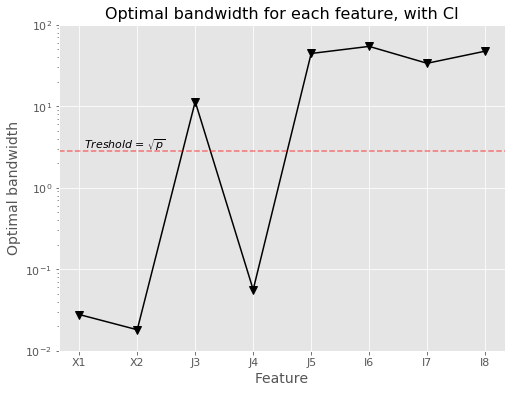

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
# create a color palette
palette = plt.get_cmap('Set1')
ax.set_yscale("log")
ax.set_xticklabels(['','X1', 'X2', 'J3', 'J4',  'J5', 'I6', 'I7', 'I8'])
ax.tick_params(labelsize=11)
plt.plot(np.arange(8), sigma, marker = 'v',markersize = 8, color = 'black')
ax.axhline(np.sqrt(8), color='red', alpha = 0.5,  linewidth  = 1.5, ls = '--')
ax.text(0.08,  3, r'Treshold = $\sqrt{p}$', style='italic', fontsize = 11)
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Optimal bandwidth', fontsize=14)
plt.title('Optimal bandwidth for each feature, with CI',fontsize=16)
plt.ylim((0.01, 100))